On pose  les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\gamma = \frac{ \mu d_c}{b \sigma H}$$

On trouve :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\bar{\Psi}[e^{\varphi}] - \gamma(\bar{v_m}-1)) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

Avec l'adimensionnement suivant : $$\bar \Psi = L_b \cdot \Psi$$

$$\Psi : v \mapsto \mathcal{K} * v$$

En définissant le noyau $\mathcal{K}$ par sa transformée de Fourier :

$$\mathcal{F}(\mathcal{K}) : k \mapsto |k| \frac{1+e^{\frac{-4}{|k|H}}}{1-e^{\frac{-4}{|k|H}}} = \frac{|k|}{\tanh(\frac{2}{|k|H})} $$

In [114]:
import numpy as np
import matplotlib.pyplot as plt

##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 100000
I = 2**7
L = I * deltaX
H = 2*L
h = 1e-2

alpha = a/b 
beta = eta*v0/(b*sigma) #=6e-08
gamma = mu*dc/(b*sigma*H)

##Calcul du gradient de la transformée de Hilbert (cf. doc)
def noyau(freq,H) :
    """
    Optimisée d'un facteur 100 par Quentin Guitet
    """
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2/H/c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)
    K = noyau(freq, H)

    F=K*2*np.pi*F

    psi=np.fft.ifft(F)
    return psi.real*Lb

##Résolution numérique de l'équation différentielle (cf. doc)
def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K +1
        if erreur < tol:
            #print(K)
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            #print(K)
            return ykk, h
        h = s*h
    #print(K)
    return ykk, h

##Système différentiel
def phidot(phi, nu):
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    #PSI = np.clip(Psi(v, deltaX, H), -100000, 100000)
    #print(np.max(PSI))
    return (v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1)))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    F1 = phidot(phi, nu)
    F2 = nudot(phi, nu)
    return np.array([F1, F2])


##Conditions initiales
x = np.arange(-L//2, L//2 + 1, deltaX)
d = L//8 #largeur de la zone de glissement initiale
amp = 1.003 #amplitude max
temps = np.array([0])

#Elliptique
Ae = []
for y in x :
    if y < d and y > -d:
        Ae.append((np.sqrt(d**2 - y**2)/d)*amp + 1)
    else :
        Ae.append(1)
        
Ae = np.array(Ae)
Be = 1/Ae

#Gaussienne
Ag = np.exp(-x**2/(d**2))*amp + np.ones(I+1)
Bg = 1/Ag

#Carré
Ac = []
for y in x :
    if y < d and y > -d:
        Ac.append(amp)
    else :
        Ac.append(1)

Ac = np.array(Ac)
Bc = 1/Ac

#Uniformes
Au = np.ones(I+1)*amp
Bu = 1/Au

##Résolution
CIv = Ac
CItheta = Bc

phik = np.log(CIv)
nuk = np.log(CItheta)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [temps[n]+h]))
    Phi.append(yk[0])
    Nu.append(yk[1])

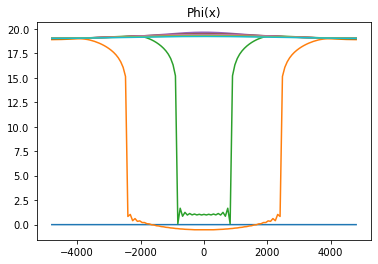

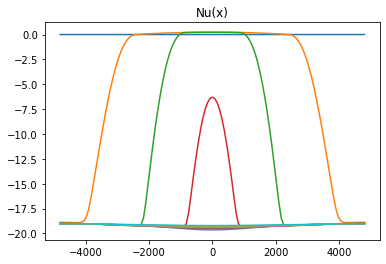

In [115]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, Phi[n])
plt.title('Phi(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, Nu[n])
plt.title('Nu(x)')
plt.show()

Text(0, 0.5, 'Vitesse en m/s')

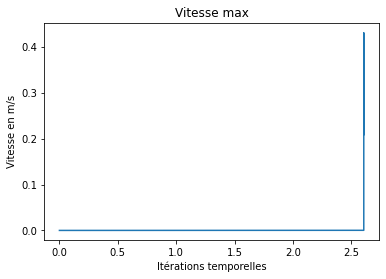

In [118]:
Mphi = np.array([np.max(f) for f in np.exp(Phi)])
t = np.arange(N+1)
plt.plot(temps, Mphi*v0)
plt.title('Vitesse max')
plt.xlabel('Itérations temporelles')
plt.ylabel('Vitesse en m/s')